In [161]:
import warnings
warnings.filterwarnings('ignore')

In [149]:
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from keras.losses import CategoricalCrossentropy
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, roc_auc_score

In [2]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Embedding, Conv1D,MaxPooling1D, Flatten, Dense,Dropout,LSTM,Bidirectional
#from keras.optimizers import RMSprop

### Load Data

In [3]:
data = pd.read_csv('yelp.csv')

In [4]:
data = data.dropna()
text = data['text'].tolist()
binstars = data['stars'].tolist()
binstars = [int(star) for star in binstars]

<AxesSubplot:ylabel='Count'>

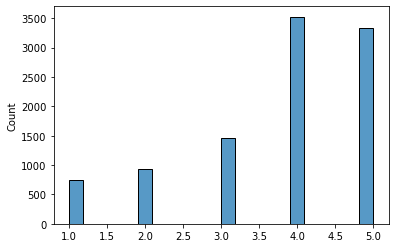

In [5]:
sns.histplot(x = binstars)

### Make a balanced dataset of positive and negative review -- 50:50

In [6]:
balanced_texts = []   # contains 50000 positive reviews and 50000 negative reviews
balanced_labels = []  
all_texts = []
all_labels = []
balanced = []
count = 500  
stars = [0, 0, 0, 0, 0]
for i in range(len(text)):
    sentiment = binstars[i]
    if stars[sentiment-1] < count:
        balanced_texts.append(text[i])
        balanced_labels.append(binstars[i])
        balanced.append(i)
        stars[sentiment-1] += 1
    all_texts.append(text[i])
    all_labels.append(binstars[i])

In [7]:
# cut reviews after 200 words
maxlen = 200 
# Number of words to consider as features
# restrict the yelp reviews to the top 1000 most common words
max_words = 10000  

#training_samples = 75000  #  train on 75000 samples
#test_samples = 25000  # test on 25000 samples

In [8]:
# create a tokenizer and it will ignore all except the 1000 most-common words
tokenizer = Tokenizer(num_words = max_words)
# use tokenizer to calculate the frequency of each word in dataset.
tokenizer.fit_on_texts(all_texts)
# convert all of reviews to lists of integers
sequences = tokenizer.texts_to_sequences(all_texts)
print(len(sequences[1]))
print(len(sequences[2]))


# use pad_sequence to make traning samples the same size, fill with zeros
data_input = pad_sequences(sequences, maxlen = maxlen)
labels = np.asarray(all_labels)

260
15


### train and test (validation) split

In [9]:
indices = np.arange(data_input.shape[0])
#np.random.shuffle(indices)
data_input = data_input[indices]
labels = labels[indices]

# train on 75000，test on 25000
#x_train = data_input[:training_samples]
#y_train = labels[:training_samples]
#x_test = data_input[training_samples: training_samples + test_samples]
#y_test = labels[training_samples: training_samples + test_samples]
#print(" x_train",x_train.shape)
#print(" y_train",y_train.shape)

x_train = np.asarray(data_input) [balanced]
y_train = np.asarray(labels) [balanced]
x_test = np.asarray(data_input)
y_test = np.asarray(labels)
print(" x_train",x_train.shape)
print(" y_train",y_train.shape)

y_train = y_train / 5
y_test = y_test / 5
#ohe = OneHotEncoder()
#y_train = y_train.reshape((2500,1))
#y_test = y_test.reshape((10000,1))
#ohe.fit_transform(y_train)
#ohe.fit_transform(y_test)

 x_train (2500, 200)
 y_train (2500,)


 ### Model 1 - Using Embedding layer and LSTM

dis one sucks LOL

In [10]:
max_words = 10000 
maxlen = 200
model = Sequential()
model.add(Embedding(max_words, 64,input_length = maxlen))
model.add(LSTM(64,dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mean_squared_error'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 64)           640000    
                                                                 
 lstm (LSTM)                 (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 673,089
Trainable params: 673,089
Non-trainable params: 0
_________________________________________________________________


In [11]:
history = model.fit(x_train, y_train,
                    epochs=5,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/5
16/16 [==============================] - 19s 818ms/step - loss: 0.0853 - mean_squared_error: 0.0853 - val_loss: 0.1690 - val_mean_squared_error: 0.1690
Epoch 2/5
16/16 [==============================] - 12s 721ms/step - loss: 0.0668 - mean_squared_error: 0.0668 - val_loss: 0.1426 - val_mean_squared_error: 0.1426
Epoch 3/5
16/16 [==============================] - 12s 720ms/step - loss: 0.0600 - mean_squared_error: 0.0600 - val_loss: 0.1218 - val_mean_squared_error: 0.1218
Epoch 4/5
16/16 [==============================] - 14s 899ms/step - loss: 0.0434 - mean_squared_error: 0.0434 - val_loss: 0.1151 - val_mean_squared_error: 0.1151
Epoch 5/5
16/16 [==============================] - 13s 811ms/step - loss: 0.0269 - mean_squared_error: 0.0269 - val_loss: 0.0825 - val_mean_squared_error: 0.0825


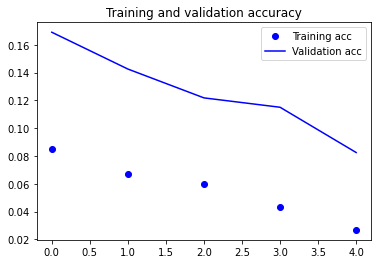

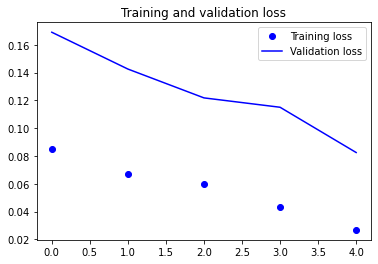

In [12]:
acc = history.history['mean_squared_error']
val_acc = history.history['val_mean_squared_error']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [13]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 18s 56ms/step - loss: 0.0398 - mean_squared_error: 0.0398


[0.03977043926715851, 0.03977043926715851]

In [14]:
train_pred = model.predict(x_train)
train_pred = np.reshape(train_pred, (2500,1))
train_pred = np.sort(train_pred, axis = 0)
print(train_pred[0])
print(train_pred[499])
print(train_pred[999])
print(train_pred[1499])
print(train_pred[1999])
print(train_pred[2499])
max1 = train_pred[499]
max2 = train_pred[999]
max3 = train_pred[1499]
max4 = train_pred[1999]
pd.DataFrame(train_pred).describe()

[0.23508042]
[0.44192517]
[0.57308984]
[0.73234755]
[0.8723601]
[0.9883945]


,0
count,2500.000000
mean,0.651416
std,0.202299
min,0.235080
25%,0.473987
50%,0.644934
75%,0.843038
max,0.988394


In [15]:
pred = model.predict(x_test)
pd.DataFrame(pred).describe()

,0
count,10000.000000
mean,0.707969
std,0.171643
min,0.235080
25%,0.580953
50%,0.730109
75%,0.854034
max,0.989015


In [16]:
pred = model.predict(x_test)
pred = np.where(pred < max1, 1, np.where(pred < max2, 2, np.where(pred < max3, 3, np.where(pred < max4, 4, 5))))
print(pd.DataFrame(pred).describe())
print(accuracy_score(newstars, pred))
print(f1_score(newstars,pred, average = 'macro'))
print(f1_score(newstars,pred, average = 'weighted'))
#diff = (y_test - pred)
#y_test = np.reshape(y_test, (10000,1))
#diff = np.reshape(diff, (10000,1))
#diff = np.where(diff == 0, 1, 0)
#df = pd.DataFrame(np.concatenate((y_test, pred, diff), axis = 1), columns=['actual', 'prediction', 'correctness'])
#df.describe()

                  0
count  10000.000000
mean       3.378900
std        1.210984
min        1.000000
25%        3.000000
50%        3.000000
75%        4.000000
max        5.000000


(0.3776, 0.3776, 0.3776)

In [17]:
pd.DataFrame(pred).describe()

,0
count,10000.000000
mean,3.378900
std,1.210984
min,1.000000
25%,3.000000
50%,3.000000
75%,4.000000
max,5.000000


In [18]:
max_words = 10000 
maxlen = 200
model = Sequential()
model.add(Embedding(max_words, 64,input_length = maxlen))
model.add(LSTM(64,dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mean_squared_error'])

In [19]:
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10
16/16 [==============================] - 18s 730ms/step - loss: 0.0841 - mean_squared_error: 0.0841 - val_loss: 0.1555 - val_mean_squared_error: 0.1555
Epoch 2/10
16/16 [==============================] - 15s 923ms/step - loss: 0.0680 - mean_squared_error: 0.0680 - val_loss: 0.1619 - val_mean_squared_error: 0.1619
Epoch 3/10
16/16 [==============================] - 14s 888ms/step - loss: 0.0605 - mean_squared_error: 0.0605 - val_loss: 0.1447 - val_mean_squared_error: 0.1447
Epoch 4/10
16/16 [==============================] - 14s 884ms/step - loss: 0.0441 - mean_squared_error: 0.0441 - val_loss: 0.0766 - val_mean_squared_error: 0.0766
Epoch 5/10
16/16 [==============================] - 14s 886ms/step - loss: 0.0273 - mean_squared_error: 0.0273 - val_loss: 0.0728 - val_mean_squared_error: 0.0728
Epoch 6/10
16/16 [==============================] - 14s 857ms/step - loss: 0.0181 - mean_squared_error: 0.0181 - val_loss: 0.0703 - val_mean_squared_error: 0.0703
Epoch 7/10
16/16 [====

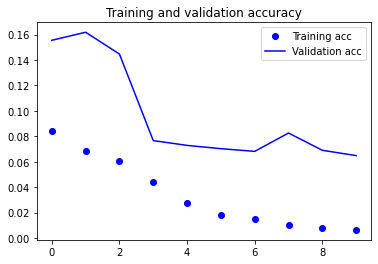

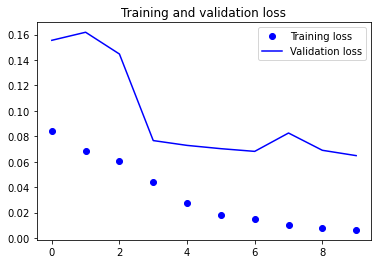

In [20]:
acc = history.history['mean_squared_error']
val_acc = history.history['val_mean_squared_error']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [21]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 16s 52ms/step - loss: 0.0431 - mean_squared_error: 0.0431


[0.04307663440704346, 0.04307663440704346]

In [22]:
train_pred = model.predict(x_train)
train_pred = np.reshape(train_pred, (2500,1))
train_pred = np.sort(train_pred, axis = 0)
print(train_pred[0])
print(train_pred[499])
print(train_pred[999])
print(train_pred[1499])
print(train_pred[1999])
print(train_pred[2499])
max1 = train_pred[499]
max2 = train_pred[999]
max3 = train_pred[1499]
max4 = train_pred[1999]

pred = model.predict(x_test)
pred = np.where(pred < max1, 1, np.where(pred < max2, 2, np.where(pred < max3, 3, np.where(pred < max4, 4, 5))))
print(pd.DataFrame(pred).describe())
print(accuracy_score(newstars, pred))
print(f1_score(newstars,pred, average = 'macro'))
print(f1_score(newstars,pred, average = 'weighted'))

[0.1557813]
[0.36654174]
[0.5409685]
[0.73363423]
[0.8865789]
[0.98593724]
                  0
count  10000.000000
mean       3.348600
std        1.234678
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        5.000000


0.4283

 ### Model 2 -  Using combination of CNN and RNN

In [23]:
model_conv = Sequential()
model_conv.add(Embedding(max_words, 128, input_length=maxlen))
model_conv.add(Dropout(0.2))
model_conv.add(Conv1D(64, 5, activation='relu'))
model_conv.add(MaxPooling1D(pool_size=3))
model_conv.add(LSTM(128))
model_conv.add(Dense(1, activation='sigmoid'))
model_conv.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
model_conv.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 200, 128)          1280000   
                                                                 
 dropout (Dropout)           (None, 200, 128)          0         
                                                                 
 conv1d (Conv1D)             (None, 196, 64)           41024     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 65, 64)           0         
 )                                                               
                                                                 
 lstm_2 (LSTM)               (None, 128)               98816     
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                      

In [24]:
history = model_conv.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10
16/16 [==============================] - 12s 443ms/step - loss: 0.0790 - mean_squared_error: 0.0790 - val_loss: 0.1003 - val_mean_squared_error: 0.1003
Epoch 2/10
16/16 [==============================] - 6s 372ms/step - loss: 0.0678 - mean_squared_error: 0.0678 - val_loss: 0.1562 - val_mean_squared_error: 0.1562
Epoch 3/10
16/16 [==============================] - 6s 400ms/step - loss: 0.0590 - mean_squared_error: 0.0590 - val_loss: 0.1263 - val_mean_squared_error: 0.1263
Epoch 4/10
16/16 [==============================] - 9s 549ms/step - loss: 0.0413 - mean_squared_error: 0.0413 - val_loss: 0.0720 - val_mean_squared_error: 0.0720
Epoch 5/10
16/16 [==============================] - 8s 507ms/step - loss: 0.0227 - mean_squared_error: 0.0227 - val_loss: 0.0694 - val_mean_squared_error: 0.0694
Epoch 6/10
16/16 [==============================] - 7s 424ms/step - loss: 0.0139 - mean_squared_error: 0.0139 - val_loss: 0.0613 - val_mean_squared_error: 0.0613
Epoch 7/10
16/16 [=========

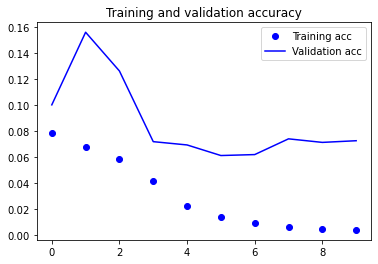

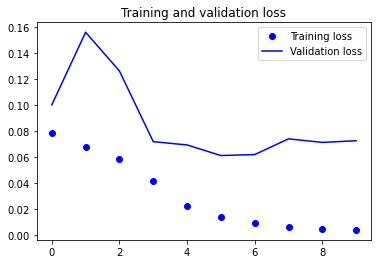

In [25]:
acc = history.history['mean_squared_error']
val_acc = history.history['val_mean_squared_error']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [26]:
model_conv.evaluate(x_test, y_test)

313/313 [==============================] - 20s 65ms/step - loss: 0.0453 - mean_squared_error: 0.0453


[0.04533024877309799, 0.04533024877309799]

In [27]:
train_pred = model.predict(x_train)
train_pred = np.reshape(train_pred, (2500,1))
train_pred = np.sort(train_pred, axis = 0)
print(train_pred[0])
print(train_pred[499])
print(train_pred[999])
print(train_pred[1499])
print(train_pred[1999])
print(train_pred[2499])
max1 = train_pred[499]
max2 = train_pred[999]
max3 = train_pred[1499]
max4 = train_pred[1999]

pred = model.predict(x_test)
pred = np.where(pred < max1, 1, np.where(pred < max2, 2, np.where(pred < max3, 3, np.where(pred < max4, 4, 5))))
print(pd.DataFrame(pred).describe())
print(accuracy_score(newstars, pred))
print(f1_score(newstars,pred, average = 'macro'))
print(f1_score(newstars,pred, average = 'weighted'))

[0.1557813]
[0.36654174]
[0.5409685]
[0.73363423]
[0.8865789]
[0.98593724]
                  0
count  10000.000000
mean       3.348600
std        1.234678
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        5.000000


0.4283

## comment
For the first two epochs, the training accuracy and validation accuract are simiar, which means that the patterns or ruls network learns on the training generalize well to the unseen validation set. However, after two epochs, this network has overfitted the training data.

#  Using bidirectional RNNs

In [28]:
from keras import backend as K
K.clear_session()

In [29]:
model = Sequential()
model.add(Embedding(max_words, 128, input_length=maxlen))
model.add(Bidirectional(LSTM(128)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',loss='mean_squared_error', metrics=['mean_squared_error'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 128)          1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 256)              263168    
 l)                                                              
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 1,543,425
Trainable params: 1,543,425
Non-trainable params: 0
_________________________________________________________________


In [30]:
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Epoch 1/10
16/16 [==============================] - 80s 5s/step - loss: 0.0780 - mean_squared_error: 0.0780 - val_loss: 0.1093 - val_mean_squared_error: 0.1093
Epoch 2/10
16/16 [==============================] - 65s 4s/step - loss: 0.0678 - mean_squared_error: 0.0678 - val_loss: 0.1609 - val_mean_squared_error: 0.1609
Epoch 3/10
16/16 [==============================] - 65s 4s/step - loss: 0.0555 - mean_squared_error: 0.0555 - val_loss: 0.0828 - val_mean_squared_error: 0.0828
Epoch 4/10
16/16 [==============================] - 73s 5s/step - loss: 0.0349 - mean_squared_error: 0.0349 - val_loss: 0.1336 - val_mean_squared_error: 0.1336
Epoch 5/10
16/16 [==============================] - 74s 5s/step - loss: 0.0215 - mean_squared_error: 0.0215 - val_loss: 0.0919 - val_mean_squared_error: 0.0919
Epoch 6/10
16/16 [==============================] - 70s 4s/step - loss: 0.0131 - mean_squared_error: 0.0131 - val_loss: 0.0725 - val_mean_squared_error: 0.0725
Epoch 7/10
16/16 [======================

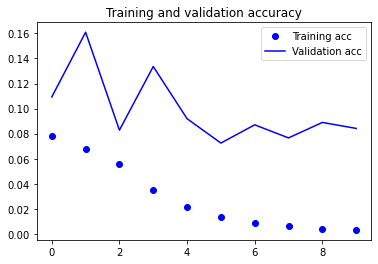

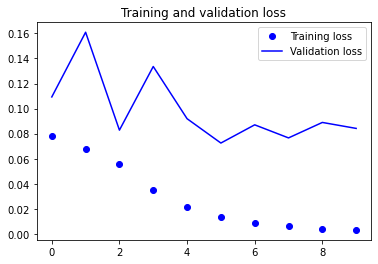

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline 
acc = history.history['mean_squared_error']
val_acc = history.history['val_mean_squared_error']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [32]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 48s 154ms/step - loss: 0.0422 - mean_squared_error: 0.0422


[0.0421636700630188, 0.0421636700630188]

In [33]:
train_pred = model.predict(x_train)
train_pred = np.reshape(train_pred, (2500,1))
train_pred = np.sort(train_pred, axis = 0)
print(train_pred[0])
print(train_pred[499])
print(train_pred[999])
print(train_pred[1499])
print(train_pred[1999])
print(train_pred[2499])
max1 = train_pred[499]
max2 = train_pred[999]
max3 = train_pred[1499]
max4 = train_pred[1999]

pred = model.predict(x_test)
pred = np.where(pred < max1, 1, np.where(pred < max2, 2, np.where(pred < max3, 3, np.where(pred < max4, 4, 5))))
print(pd.DataFrame(pred).describe())
print(accuracy_score(newstars, pred))
print(f1_score(newstars,pred, average = 'macro'))
print(f1_score(newstars,pred, average = 'weighted'))

[0.12262642]
[0.38519293]
[0.5834906]
[0.7835212]
[0.9278859]
[0.9945991]
                 0
count  10000.00000
mean       3.30650
std        1.24214
min        1.00000
25%        2.00000
50%        3.00000
75%        4.00000
max        5.00000


0.4281

In [34]:
print(pd.DataFrame(5 * y_train).describe())
print(pd.DataFrame(5*y_test).describe())

                 0
count  2500.000000
mean      3.000000
std       1.414496
min       1.000000
25%       2.000000
50%       3.000000
75%       4.000000
max       5.000000
                  0
count  10000.000000
mean       3.777500
std        1.214636
min        1.000000
25%        3.000000
50%        4.000000
75%        5.000000
max        5.000000


In [151]:
newdata = pd.read_json('yelp_academic_dataset_review.json', lines = True, encoding_errors = 'ignore', nrows = 100000)
newdata.describe()

,stars,useful,funny,cool
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,3.842910,0.898980,0.257180,0.347030
std,1.354729,2.205186,1.010212,1.066382
min,1.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,0.000000,0.000000
50%,4.000000,0.000000,0.000000,0.000000
75%,5.000000,1.000000,0.000000,0.000000
max,5.000000,320.000000,98.000000,49.000000


In [152]:
newtext = newdata['text'].tolist()
newstars = newdata['stars'].tolist()
newstars = [float(star) for star in newstars]

newsequences = tokenizer.texts_to_sequences(newtext)
print(len(newsequences[1]))
print(len(newsequences[2]))
newdata_input = pad_sequences(newsequences, maxlen = maxlen)

144
54


In [153]:
newdata_labels = np.asarray(newstars)
newdata_labels = newdata_labels/5
newdata_input = np.asarray(newdata_input)
#newdata_labels = np.where(newdata_labels < 0.21, 0.2, np.where(newdata_labels < 0.41, 0.4, np.where(newdata_labels < 0.61, 0.6, np.where(newdata_labels < 0.81, 0.8, 1.0))))
print(newdata_input[:10])
print(newdata_labels[:10])

[[   0    0    0 ...   32  400 5862]
 [   0    0    0 ... 2919   11 1144]
 [   0    0    0 ...    5    1  512]
 ...
 [   0    0    0 ...   17 1700 1357]
 [   0    0    0 ...  172   66 2091]
 [   0    0    0 ...  521   50   65]]
[0.6 1.  0.6 1.  0.8 0.2 1.  1.  0.6 0.6]


In [154]:
pred = model.predict(newdata_input)
pred = np.where(pred < max1, 1, np.where(pred < max2, 2, np.where(pred < max3, 3, np.where(pred < max4, 4, 5))))
print(pd.DataFrame(pred).describe())
print(accuracy_score(newstars, pred))
print(f1_score(newstars,pred, average = 'macro'))
print(f1_score(newstars,pred, average = 'weighted'))


                   0
count  100000.000000
mean        3.343020
std         1.250157
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max         5.000000
0.3465
0.3246084254092899
0.376561974012492


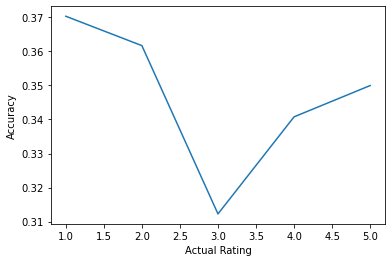

In [162]:
corr = [0,0,0,0,0,0]
tot = [0,0,0,0,0,0]
for i in range(len(pred)):
    if newstars[i] == pred[i]:
        corr[int(newstars[i])] += 1
    tot[int(newstars[i])] += 1
    
plt.plot(np.asarray(corr)/np.asarray(tot))
plt.ylabel('Accuracy')
plt.xlabel('Actual Rating')
plt.show()